In [1]:
import os

import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./preprocessed_apartment.csv')
df.head()

,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
0,8,1,1156,1504,196.21,450000.0,13.0,211.23,1976.06,480.0,120.0,7582.0,7043.0,2018,12
1,8,1,1706,4942,202.58,450000.0,5.0,252.31,2010.07,19.0,1.0,7343.0,5896.0,2018,12
2,8,1,1156,9746,139.83,320000.0,7.0,165.29,1982.04,1924.0,168.0,7565.0,6400.0,2018,12
3,8,1,393,15322,191.04,315000.0,2.0,219.22,1983.12,1204.0,84.0,5451.0,4750.0,2018,12
4,8,1,1156,1509,144.20,304000.0,10.0,158.68,1979.05,560.0,168.0,6969.0,6333.0,2018,12


In [3]:
df.shape

(6174900, 15)

In [4]:
df = df.sample(n=600000)
print(df.shape)
df.head()

(600000, 15)


,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
5968526,15,113,1537,13917,59.99,6420.0,4.0,72.54,2004.07,1998.0,498.0,354.0,293.0,2011,3
543862,8,66,1207,14272,59.76,37400.0,6.0,72.82,2003.07,466.0,112.0,2069.0,1698.0,2011,1
1819152,1,112,1569,13059,59.98,10500.0,5.0,69.42,1997.11,630.0,70.0,579.0,500.0,2006,11
5741980,12,45,398,16272,28.98,5300.0,8.0,39.67,1996.09,470.0,470.0,605.0,442.0,2016,9
5358929,11,71,1353,11910,58.50,9850.0,11.0,79.34,1989.10,941.0,145.0,557.0,410.0,2007,5


In [5]:
y = df['price']
del df['price']

In [6]:
x_train, x_test,y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=0)

In [7]:
lightgbm = lgb.LGBMRegressor(random_state=0)

In [8]:
kfold = KFold(n_splits=5, random_state=0).get_n_splits(x_train.values)
cross_val_score(lightgbm, x_train.values, y_train)

C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.99429666, 0.99469274, 0.99649409])

In [9]:
lightgbm.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [10]:
modelPred = lightgbm.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

1351.4021822575896

In [11]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 23500.000, 예상가격: 23120.908
실제가격: 30000.000, 예상가격: 30094.639
실제가격: 21700.000, 예상가격: 21536.949
실제가격: 31898.000, 예상가격: 32634.823
실제가격: 30000.000, 예상가격: 29639.845
실제가격: 22500.000, 예상가격: 22776.698
실제가격: 21600.000, 예상가격: 21624.033
실제가격: 11400.000, 예상가격: 11543.248
실제가격: 24500.000, 예상가격: 24293.734
실제가격: 7900.000, 예상가격: 7672.025


In [12]:
model = Sequential()
model.add(Dense(140, input_dim=14, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['accuracy'])

In [14]:
# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
# 모델 저장 조건 설정
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
# loss는 train loss고 val_loss는 validation loss임 / acc도 마찬가지

In [15]:
history = model.fit(x_train, y_train, validation_split=0.4, epochs=100, batch_size=1000, callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 252000 samples, validate on 168000 samples
Epoch 1/100
252000/252000 [==============================] - 4s 17us/step - loss: 327927133.8095 - acc: 3.9683e-05 - val_loss: 112480874.0476 - val_acc: 8.3333e-05

Epoch 00001: val_loss improved from inf to 112480874.04762, saving model to ./model/01-112480874.0476.hdf5
Epoch 2/100
252000/252000 [==============================] - 2s 7us/step - loss: 106758777.2381 - acc: 1.0714e-04 - val_loss: 90762074.0476 - val_acc: 1.7857e-04

Epoch 00002: val_loss improved from 112480874.04762 to 90762074.04762, saving model to ./model/02-90762074.0476.hdf5
Epoch 3/100
252000/252000 [==============================] - 2s 9us/step - loss: 80330879.6032 - acc: 1.8254e-04 - val_loss: 60312376.3333 - val_acc: 1.2500e-04

Epoch 00003: val_loss improved from 90762074.04762 to 60312376.33333, saving model to ./model/03-60312376.3333.hdf5
Epoch 4/100
252000/252000 [==============================] - 2s 8us/st


Epoch 00032: val_loss improved from 334097.06631 to 245235.68318, saving model to ./model/32-245235.6832.hdf5
Epoch 33/100
252000/252000 [==============================] - 2s 7us/step - loss: 369353.6798 - acc: 0.0015 - val_loss: 402504.8537 - val_acc: 8.5714e-04

Epoch 00033: val_loss did not improve from 245235.68318
Epoch 34/100
252000/252000 [==============================] - 2s 8us/step - loss: 429454.7693 - acc: 0.0013 - val_loss: 263848.1483 - val_acc: 0.0018

Epoch 00034: val_loss did not improve from 245235.68318
Epoch 35/100
252000/252000 [==============================] - 2s 8us/step - loss: 372179.4210 - acc: 0.0014 - val_loss: 238855.1257 - val_acc: 0.0022

Epoch 00035: val_loss improved from 245235.68318 to 238855.12574, saving model to ./model/35-238855.1257.hdf5
Epoch 36/100
252000/252000 [==============================] - 2s 9us/step - loss: 442525.6327 - acc: 0.0012 - val_loss: 265596.9358 - val_acc: 0.0017

Epoch 00036: val_loss did not improve from 238855.12574
Epo

252000/252000 [==============================] - 2s 9us/step - loss: 178969.2328 - acc: 0.0020 - val_loss: 185939.8362 - val_acc: 0.0020

Epoch 00070: val_loss did not improve from 137821.63137
Epoch 71/100
252000/252000 [==============================] - 2s 8us/step - loss: 256011.5284 - acc: 0.0018 - val_loss: 134993.8125 - val_acc: 0.0029

Epoch 00071: val_loss improved from 137821.63137 to 134993.81255, saving model to ./model/71-134993.8125.hdf5
Epoch 72/100
252000/252000 [==============================] - 2s 8us/step - loss: 354050.4944 - acc: 0.0015 - val_loss: 580464.9092 - val_acc: 2.1429e-04

Epoch 00072: val_loss did not improve from 134993.81255
Epoch 73/100
252000/252000 [==============================] - 2s 9us/step - loss: 315648.8227 - acc: 0.0017 - val_loss: 196094.2729 - val_acc: 0.0028

Epoch 00073: val_loss did not improve from 134993.81255
Epoch 74/100
252000/252000 [==============================] - 2s 9us/step - loss: 420538.2821 - acc: 0.0013 - val_loss: 276010.

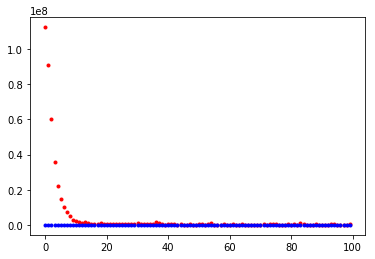

In [16]:
# y_vloss에 테스트셋으로 실험 결과의 오차 값을 저장
y_vloss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()

In [17]:
modelPred = model.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

624.0074937537756

In [18]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 23500.000, 예상가격: 23591.037
실제가격: 30000.000, 예상가격: 29815.096
실제가격: 21700.000, 예상가격: 21802.906
실제가격: 31898.000, 예상가격: 31814.689
실제가격: 30000.000, 예상가격: 31398.814
실제가격: 22500.000, 예상가격: 22781.340
실제가격: 21600.000, 예상가격: 21379.834
실제가격: 11400.000, 예상가격: 11330.009
실제가격: 24500.000, 예상가격: 24199.754
실제가격: 7900.000, 예상가격: 7795.036


In [22]:
model = load_model('./model/98-110247.4128.hdf5')

In [23]:
modelPred = model.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

336.66060303402145

In [24]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 23500.000, 예상가격: 23615.373
실제가격: 30000.000, 예상가격: 29814.570
실제가격: 21700.000, 예상가격: 21787.348
실제가격: 31898.000, 예상가격: 31797.664
실제가격: 30000.000, 예상가격: 30276.643
실제가격: 22500.000, 예상가격: 22634.717
실제가격: 21600.000, 예상가격: 21802.795
실제가격: 11400.000, 예상가격: 11534.054
실제가격: 24500.000, 예상가격: 24443.754
실제가격: 7900.000, 예상가격: 7915.490
